In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback
from keras.layers import Lambda
# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import inspect

Using TensorFlow backend.


# Load Data

## Utilities

In [3]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [4]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Process data

In [3]:
# Path to downloaded data from Zenodo
data_dir = './data/'

In [4]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [7]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [8]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)

In [10]:
X_train, X_test, Y_train, Y_test = data_split(X_fit, Y_fit, test=0.2, shuffle=True)

In [11]:
#smaller data sets
X_train_small = X_train[0:int(0.8*10**5)]
Y_train_small = Y_train[0:int(0.8*10**5)]
X_test_small = X_test[0:int(0.2*10**5)]
Y_test_small = Y_test[0:int(0.2*10**5)]

# Load Model

In [13]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

# load model from saved file
# model trained in original alphaS notebook
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_alphaS.h5')

# Fitting

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [34]:
# Defining reweighting functions

def reweight(d): #from NN (DCTR)
    f = dctr.model(d) # Use dctr.model.predict_on_batch(d) when using outside training
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

In [15]:
model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs = model.inputs[0]
batch_size = 1000

def my_loss_wrapper(inputs,val=0):
    x  = inputs #x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    #Creating theta_prime
    alphaS = K.ones(shape =x.shape[0:2])*val # Fitting parameter
    aLund = K.ones(shape =x.shape[0:2])*0.68 # Fixed at default
    probStoUD = K.ones(shape =x.shape[0:2])*0.217 # Fixed at default
    theta_prime = K.stack((alphaS, aLund, probStoUD), axis = 2)


    data = K.concatenate((x, theta_prime), axis =2)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    w = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean-Squared Loss:
        t_loss = (y_true)*(y_true - y_pred)**2 +(w)*(1-y_true)*(y_true - y_pred)**2
        
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

In [16]:
thetas = np.linspace(0.13, 0.17, 9) #iterating across possible alphaS values
vlvals = []
lvals = []


for theta in thetas:
    print("trainnig theta = :", theta)
    model.model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1)
    vlvals+=[history.history['val_loss']]
    lvals+=[history.history['loss']]
    print
    pass
print(lvals)

testing theta = : 0.13
(1000, 51, 7)
dtype: <dtype: 'float32'>
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 377s 262us/step - loss: 0.2464 - acc: 0.5727 - val_loss: 0.2431 - val_acc: 0.5805
testing theta = : 0.135
(1000, 51, 7)
dtype: <dtype: 'float32'>
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 356s 247us/step - loss: 0.2530 - acc: 0.5690 - val_loss: 0.2526 - val_acc: 0.5723
testing theta = : 0.14
(1000, 51, 7)
dtype: <dtype: 'float32'>
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 360s 250us/step - loss: 0.2554 - acc: 0.5556 - val_loss: 0.2552 - val_acc: 0.5677
testing theta = : 0.14500000000000002
(1000, 51, 7)
dtype: <dtype: 'float32'>
Train on 1440000 samples, validate on 360000 sam

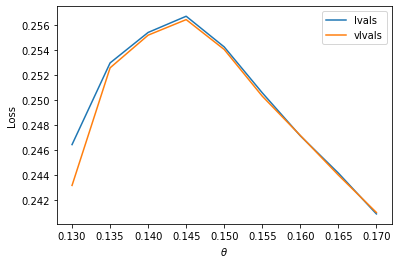

In [21]:
plt.plot(thetas,lvals, label = "lvals")
plt.plot(thetas,vlvals, label = "vlvals")
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("MSE for alphaS altFit2.png")

#incorrect maxima value? should be at alphaS = theta = 0.160

In [19]:
#sanity check to ensure that "data" is being constructed properly

'''
x  = X_test
print(x.shape)
#x = K.squeeze(x, axis = 1)
x = tf.gather(x, np.arange(2))
x = tf.gather(x, np.arange(51), axis = 1)
print(x.shape)

par1 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.16
par2 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.68
par3 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.217
par = K.stack((par1, par2, par3), axis = 2)

#combining and reshaping into correct format:
#data = K.stack((x, theta0_stack), axis=-1) 
data = K.concatenate((x, par), axis =2)
print(data.shape)
w = reweight(data)
print(w.shape)
'''

'\nx  = X_test\nprint(x.shape)\n#x = K.squeeze(x, axis = 1)\nx = tf.gather(x, np.arange(2))\nx = tf.gather(x, np.arange(51), axis = 1)\nprint(x.shape)\ntheta = 0. #starting value\n#theta0 = tf.constant(val, dtype= tf.float32)#target value\n\npar1 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.16\npar2 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.68\npar3 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.217\npar = K.stack((par1, par2, par3), axis = 2)\n\n#creating tensor with same shape as inputs, with val in every entry\n#theta0_stack = K.constant(val, dtype=tf.float32, shape = x.shape)\n#combining and reshaping into correct format:\n#data = K.stack((x, theta0_stack), axis=-1) \ndata = K.concatenate((x, par), axis =2)\nprint(data.shape)\nw = reweight(data)\nprint(w.shape)\n'

In [20]:
'''
with tf.Session() as sess:
    print(K.eval(data))
'''

'\nwith tf.Session() as sess:\n    print(K.eval(data))\n'